# Regression

This notebook walks through regression, and present the probabilistic formulation of known regression methods that underpins generative modeling.

### Table of contents

1. [**Synthetic data**](#data)
2. [**Linear regression**](#linear)
    - [Least squares criterion](#linear_ls)
    - [Bayesian linear regression](#linear_bayes)
    - [Relation to least squares](#linear_rel)
3. [**Linear basis function regression**](#basis)
    - [Basis function expansion and feature maps](#basis_map)
    - [Going probabilistic](#basis_prob)
    - [Beyond one-dimensional inputs](#basis_1d)
4. [**Gaussian process regression**](#gp)
    - [Kernel trick](#gp_trick)
    - [A note on non-Gaussian observations](#gp_note)
5. [**Comparing methods**](#notes)

In [1]:
import numpy as np
import scipy as sc

import jax
import jax.numpy as jnp
import jax.scipy as jsc

from jax.example_libraries import optimizers

import matplotlib.pyplot as plt


jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_enable_x64', True)

<a id='data'></a>
## 1. Synthetic data

For real world data, noise $\epsilon_i$ is always present and 

$$ y_i = f(x_i) + \epsilon_i $$

for data points $i = 1, 2, \ldots, N$. This setup is common in neuroscience when relating neural activity $y$ to experimental stimuli or behaviour $x$, with the noise accounting for neural variability.

In [2]:
def func_linear(x):
    return 0.2 * x

def func_nonlinear(x):
    return 5. * np.sin(3 * x) + x**2

In [3]:
# generate data
rng = np.random.default_rng(123)  # seed everything

N = 100
N_test = 50

x_data = 6 * rng.uniform(size=(N,)) - 3
x_test = 6 * rng.uniform(size=(N_test,)) - 3

In [4]:
# linear data
std = 0.1
y_linear_cov = std**2 * jnp.eye(N)
eps = std * rng.normal(size=(N,))
y_linear = func_linear(x_data) + eps
eps = std * rng.normal(size=(N_test,))
y_linear_test = func_linear(x_test) + eps

# nonlinear data
std = 1.0
y_nonlinear_cov = std**2 * jnp.eye(N)
eps = std * rng.normal(size=(N,))
y_nonlinear = func_nonlinear(x_data) + eps
eps = std * rng.normal(size=(N_test,))
y_nonlinear_test = func_nonlinear(x_test) + eps

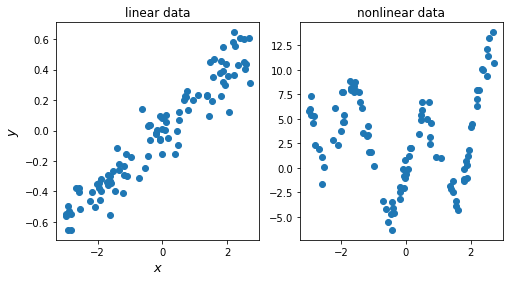

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].scatter(x_data, y_nonlinear)

plt.show()

In [6]:
def compute_R2(f, y):
    return 1 - ((y - f)**2).mean() / y.var()

<a id='linear'></a>
## 2. Linear regression


<a id='linear_ls'></a>
### 2.1 Least squares
To model dependencies between two variables, say $x$ and $y$, one of the simplest but most widely used methods is linear regression. As the name suggests, it attempts to capture their relation using a linear function 

$$ f(x) = w \cdot x + b $$



To select the parameters $w$ and $b$ that best describe the data, the common criterion is least squares. Here, we require such parameters to minimize the squared errors 

$$ L = \frac{1}{N} \sum_i \| y_i - f(x_i) \|^2 $$


For linear regression, the least squares optimization problem $ \min_{w,b} L $ has a closed form solution 

$$ \min_{w,b} L = \min_{w,b} \frac{1}{N} \sum_i \| y_i - w \cdot x_i - b \|^2 $$

$$ \partial_w L = 0 \Rightarrow \sum_i x_i \, ( y_i - w \cdot x_i - b  ) = 0 $$

$$ \partial_b L = 0 \Rightarrow \sum_i ( y_i - w \cdot x_i - b  ) = 0 $$

Solving these equations, we obtain 

$$ w = \frac{\frac{1}{N} \sum_i x_i y_i - \bar{x} \bar{y}}{\text{Var}(x)} $$

$$ b = \frac{\frac{1}{N} \sum_i x_i^2 y_i - \bar{x} \frac{1}{N} \sum_i x_i y_i}{\text{Var}(x)} $$

In [7]:
def linear_regression(x, y):
    w = ((x * y).mean() - x.mean() * y.mean()) / x.var()
    b = ((x**2 * y).mean() - x.mean() * (x * y).mean()) / x.var()
    return w, b

In [8]:
w_lin, b_lin = linear_regression(x_data, y_linear)
w_non, b_non = linear_regression(x_data, y_nonlinear)

# compute test performance
f_linear_test = w_lin * x_test + b_lin
f_nonlinear_test = w_non * x_test + b_non

R2_linear = compute_R2(f_linear_test, y_linear_test)
R2_nonlinear = compute_R2(f_nonlinear_test, y_nonlinear_test)

linear_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
}

# plot
x_plot = np.linspace(-4., 4., 300)
f_linear = w_lin * x_plot + b_lin
f_nonlinear = w_non * x_plot + b_non

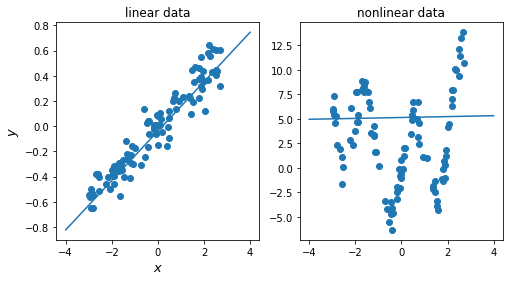

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].plot(x_plot, f_linear)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].plot(x_plot, f_nonlinear)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

For didactic purposes, we derived linear regression from scratch. As linear regression is a widely used tool, standard implementations are readily available in libraries like [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).


<a id='linear_bayes'></a>
### 2.2 Bayesian linear regression

Instead of the least squares perspective above, one can start thinking in terms of how the data was generated. Above, we did not specify the statistical properties of the observation noise $\epsilon$. In a generative modeling approach, we have to be more explicit and state our assumptions about the data generation process. Conventionally, we choose $\epsilon$ to be i.i.d. Gaussian noise 

$$ \epsilon \sim \mathcal{N}(0, \sigma^2) $$

and we 

$$ w, b \sim \mathcal{N}(0, 1) $$


Treating the unknown model parameters as random variables now defines a distribution over all possible models $p\left( f(x) \right)$, and we can visualize samples drawn from this distribution. Each sample is a different possible "explanation" of the data that our generative model can yield.

In [10]:
N_samps = 5

x_plot = np.linspace(-4., 4., 100)

w, b = rng.normal(size=(N_samps,)), rng.normal(size=(N_samps,))
f_samps = (w[:, None] * x_plot + b[:, None]).T  # (evals, samps)

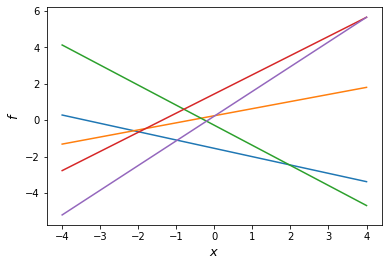

In [11]:
plt.plot(x_plot, f_samps)
plt.xlabel(r'$x$', fontsize=13)
plt.ylabel(r'$f$', fontsize=13)
plt.show()

We thus see that our generative model defines a distribution of what we expect the data to look like, before actually observing any data! This is called the prior distribution ins Bayesian inference, and observing data allows us to apply Bayes' rule 

$$ p(\theta | y) = \frac{p(y | \theta) \, p(\theta)}{p(y)} $$

to obtain our current belief of what the parameters $\theta = (w, b)$ should be. Unlike with least squares, we have an entire distribution over the $\theta$ expressing our uncertainty in estimating each parameter. This is called the posterior distribution.


Applied to the linear regression model, we have 

$$ p(w|y) =  $$


Instead of the weights, we can write the corresponding distribution over function values 

$$ p(f|y) = $$

In [12]:
def MVN_posterior(Kxs, Kxx, Kss, y_obs, y_cov):
    N = Kxx.shape[-1]
    
    Le = jnp.linalg.cholesky(Kxx + y_cov)
    Ley = jsc.linalg.solve_triangular(Le, y_obs[:, None], lower=True)
    LeK = jsc.linalg.solve_triangular(Le, Kxs, lower=True)
    
    pred_mean = LeK.T @ Ley
    pred_cov = Kss - LeK.T @ LeK
    
    return pred_mean[:, 0], pred_cov


def MVN_log_marginal(Kxs, Kxx, Kss, y_obs, y_cov):
    d_x = y_obs.shape[0]
    
    Kxx = kernel_func(params, x_obs, x_obs)
    
    Le = jnp.linalg.cholesky(Kxx + y_cov)
    Ley = jsc.linalg.solve_triangular(Le, y_obs[:, None], lower=True)
    
    lml = -.5 * (Ley.T @ Ley).sum() - .5 * d_x * jnp.log(2 * jnp.pi) - jnp.log(jnp.diag(Le)).sum()
    return lml


def Gramian(x, y, phi_func):
    Phi_x = phi_func(x)
    Phi_y = phi_func(y)
    Kxy = Phi_x @ Phi_y.T
    return Kxy

In [13]:
def phi_linear(x):  # numerically more stable would be to rescale each basis to O(1) range
    return jnp.stack([x**0, x**1], axis=1)  # (N, dims)

As we observe more data, our posterior becomes more certain. This is intuitive as we obtain more and more information.

In [14]:
Kxx = Gramian(x_data, x_data, phi_linear)
Kxs = Gramian(x_data, x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = jnp.diag(post_cov)


Kxx = Gramian(x_data, x_data, phi_linear)
Kxs = Gramian(x_data, x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = jnp.diag(post_cov)

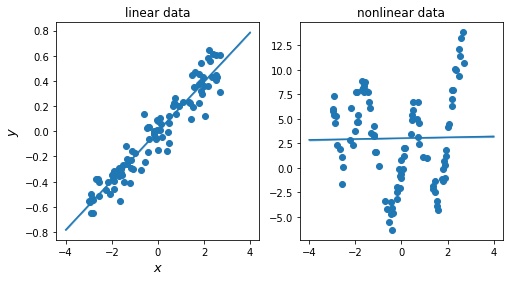

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

The probabilistic approach naturally assigns a number to how well the data $y$ is described, called the marginal likelihood 

$$ p(y) = \int p(y|w,b) \, p(w) \, p(b) \, \mathrm{d}w \, \mathrm{d}b$$

In [16]:
Kxs = Gramian(x_data, x_test, phi_linear)
Kss = Gramian(x_test, x_test, phi_linear)
post_mean_linear, _ = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_mean_nonlinear, _ = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)

R2_linear = compute_R2(post_mean_linear, y_linear_test)
R2_nonlinear = compute_R2(post_mean_nonlinear, y_nonlinear_test)

blinear_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
    #"LML_linear": , 
    #"LML_nonlinear": , 
}

<a id='linear_rel'></a>
### 2.3 Relation to least squares


Least squares can be seen as equivalent to maximum likelihood in the probabilistic perspective, where we obtain point estimates of the parameters rather than full posterior distributions.

Note the prior plays the role of a regularizer, and this is referred to as maximum a posteriori (MAP) estimation

<a id='basis'></a>
## 3. Linear basis function regression


<a id='basis_map'></a>
### 3.1 Basis function expansion and feature maps
So far, our statistical models only account for linear relations between $x$ and $y$. To go beyond linear, we can introduce basis functions to expand the input space. For example, we can introduce a cubic polynomial 

$$ \mathbf{\phi}(x) = [1, x, x^2, x^3] $$

and have the correponding vector of weights $\mathbf{w}$ 

$$ f(x) = \mathbf{w} \cdot \mathbf{\phi}(x) $$

Note that in the vector notation for linear regression, we absorb $w$ and $b$ into a single vector $\mathbf{w}$.


We can write the basis expansion as a matrix 

$$ \Phi_{ki} = \phi_k(x_i)$$

and we can derive the least squares solution in a similar manner 

$$ \mathbf{w} = (\Phi \Phi^T)^{-1} \Phi \mathbf{y} $$


In [17]:
def phi_cubic(x):  # numerically more stable would be to rescale each basis to O(1) range
    return jnp.stack([x**0, x**1, x**2, x**3], axis=1)  # (N, dims)

In [53]:
feature_mat = phi_cubic(x_data)
pseudo_inv = jnp.linalg.pinv(feature_mat)

# test performance
feature_test = phi_cubic(x_test)

w_linear = pseudo_inv @ y_linear[:, None]
f_linear = (feature_test @ w_linear)[:, 0]

w_nonlinear = pseudo_inv @ y_nonlinear[:, None]
f_nonlinear = (feature_test @ w_nonlinear)[:, 0]

R2_linear = compute_R2(f_linear, y_linear_test)
R2_nonlinear = compute_R2(f_nonlinear, y_nonlinear_test)

basis_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
}


# plotting
feature_plot = phi_cubic(x_plot)

w_linear = pseudo_inv @ y_linear[:, None]
f_linear = feature_plot @ w_linear

w_nonlinear = pseudo_inv @ y_nonlinear[:, None]
f_nonlinear = feature_plot @ w_nonlinear

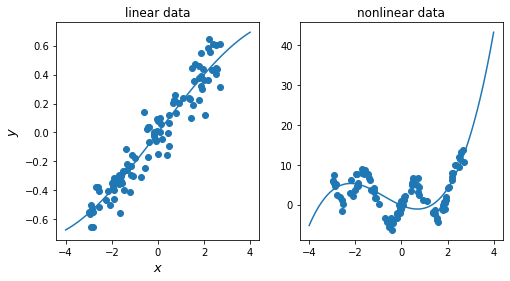

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].plot(x_plot, f_linear)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].plot(x_plot, f_nonlinear)
axes[1].scatter(x_data, y_nonlinear)

plt.show()


<a id='basis_prob'></a>
### 3.2 Going probabilistic

Note the Gramian matrix 

$$ K = \Phi^T \Phi $$

In the probabilistic picture, we have the prior over function points $\mathbf{f} = [f(x_1), \ldots, f(x_N)]$

$$ p(\mathbf{f}) = \mathcal{N}(0, K)$$

which follows form the relation $\mathbf{f} = \Phi^T \mathbf{w}$ with $\mathbf{w} \sim \mathcal{N}(0, I)$.

In [21]:
# sample
N_samps = 5

x_plot = np.linspace(-4., 4., 100)
feature_plot = phi_cubic(x_plot)

w = rng.normal(size=(feature_plot.shape[-1], N_samps))
f_samps = feature_plot @ w  # (evals, samps)

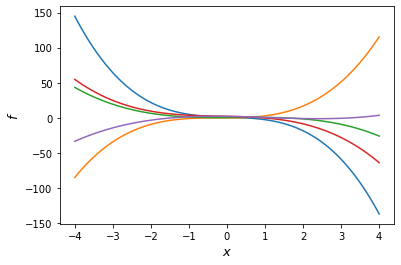

In [22]:
plt.plot(x_plot, f_samps)
plt.xlabel(r'$x$', fontsize=13)
plt.ylabel(r'$f$', fontsize=13)
plt.show()

In [23]:
Kxx = Gramian(x_data, x_data, phi_cubic)
Kxs = Gramian(x_data, x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = jnp.diag(post_cov)


Kxx = Gramian(x_data, x_data, phi_cubic)
Kxs = Gramian(x_data, x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = jnp.diag(post_cov)

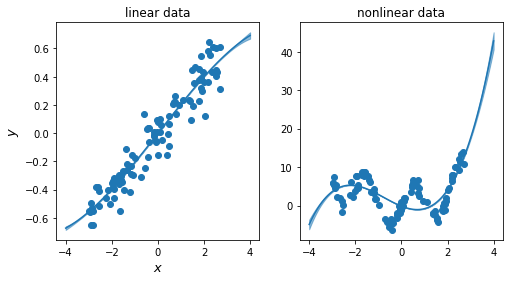

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

The marginal likelihood here 

In [25]:
Kxs = Gramian(x_data, x_test, phi_cubic)
Kss = Gramian(x_test, x_test, phi_cubic)
post_mean_linear, _ = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_mean_nonlinear, _ = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)

R2_linear = compute_R2(post_mean_linear, y_linear_test)
R2_nonlinear = compute_R2(post_mean_nonlinear, y_nonlinear_test)

bbasis_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
    #"LML_linear": , 
    #"LML_nonlinear": , 
}

Analogous to the relation between regularized least squares and Bayesian linear regression, the point estimate version here is commonly known as [kernel ridge regression](https://web2.qatar.cmu.edu/~gdicaro/10315-Fall19/additional/welling-notes-on-kernel-ridge.pdf).

<a id='basis_1d'></a>
### Beyond one-dimensional inputs

The above assumes only one input dimension. Often, one wants to find relations between some observations and multi-dimensional inputs, e.g. 2D animal position $\mathbf{x} = (x_1, x_2)$. A straightforward extension is to concatenate the expansion of the dimensions, i.e. 

$$
\phi(\mathbf{x}) = (1, x_1, x_1^2, x_2, x_2^2 , \ldots)
$$

but this will only yield functions that decompose across input dimensions $f(x_1, x_2) = f_1(x_1) + f_2(x_2)$. To obtain more general functions $f(x_1, x_2)$, we need to introduce interactions in our basis expansion set 

$$
\phi(\mathbf{x}) = (1, x_1, x_1^2, x_2, x_2^2 , x_1 x_2 , \ldots)
$$



In [26]:
def phi_2D_quad(x):
    x_1, x_2 = x[:, 0], x[:, 1]
    return jnp.stack([x_1**0, x_1**1, x_1**2, x_2**1, x_2**2, x_1 * x_2], axis=1)  # (N, dims)


In [27]:
N_samps = 4

# sample functions
x_2D = np.meshgrid(np.linspace(-3., 3., 40), np.linspace(-3., 3., 40))
x_2D = np.stack(x_2D, axis=-1).reshape(-1, 2)

feature_plot = phi_2D_quad(x_2D)

w = rng.normal(size=(feature_plot.shape[-1], N_samps))
f_samps = feature_plot @ w  # (evals, samps)
f_samps = f_samps.reshape(40, 40, N_samps)

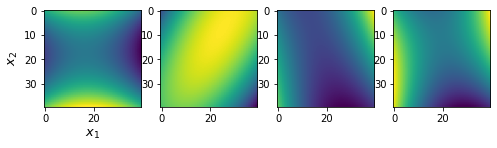

In [28]:
fig, axes = plt.subplots(1, N_samps, figsize=(8, 4))

axes[0].set_xlabel(r'$x_1$', fontsize=13)
axes[0].set_ylabel(r'$x_2$', fontsize=13)

for k in range(N_samps):
    axes[k].imshow(f_samps[..., k])
    
plt.show()

<a id='gp'></a>
## 4. Gaussian process regression

For a video introduction to the use of Gaussian processes in systems neuroscience, see this [link](https://www.youtube.com/watch?v=cQAPIlMeL_g).

<a id='gp_trick'></a>
### 4.1 Kernel trick
Instead of specifying the explicit basis expansion, we note that the expressions for evaluating function values $f(x)$ only involve combinations of the Gramian matrix $K = \Phi^T \Phi$. This is known as the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick) in the machine learning literature. Essentially, we use the Gramian matrix as a covariance function. For example, the quadratic basis set can be expresssed equivalently up to scaling coefficients using a quadratic kernel 

$$ k(x, x') = (1 + \mathbf{x} \cdot \mathbf{x}')^2$$

In particular, by specifying the kernel directly we can implicitly work with infinite basis sets. The squared exponential kernel or radial basis function 

$$ k(x, x') = \sigma^2 e^{-\|x - x'\|^2 / 2} $$

is an example of this. The covariance function and corresponding function samples look like this:

In [29]:
def SE_kernel(params, x, y):
    sigma, l = jnp.exp(params["log_sigma"]), jnp.exp(params["log_len"])
    
    x = x[:, None, :]
    y = y[None, ...]
    dist_squared = x**2 + y**2 - 2 * x * y  # (N, N, dims)
    norm_dist = (dist_squared / l**2).sum(-1)
    
    return sigma**2 * jnp.exp(-.5 * norm_dist)

In [30]:
d_x = 1
x = jnp.linspace(0., 1., 100)[:, None]
y = jnp.linspace(0., 1., 100)[:, None]

params_lin = {"log_sigma": jnp.array(0.), "log_len": jnp.zeros(d_x)}
params_non = {"log_sigma": jnp.array(0.), "log_len": jnp.zeros(d_x)}

K = SE_kernel(params_lin, x, y)

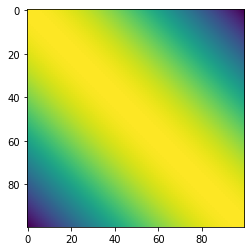

In [31]:
plt.imshow(K)
plt.show()

In [32]:
Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])

Lss = jnp.linalg.cholesky(Kss + 1e-5 * jnp.eye(Kss.shape[1]))

f_samps = Lss @ rng.normal(size=(Lss.shape[-1], N_samps))

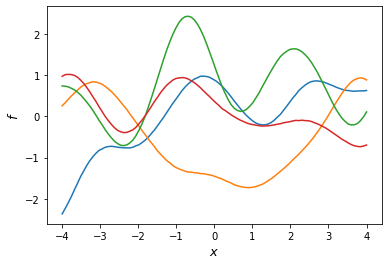

In [33]:
plt.plot(x_plot, f_samps)
plt.xlabel(r'$x$', fontsize=13)
plt.ylabel(r'$f$', fontsize=13)
plt.show()

We can now compute the posterior distribution under the observations.

In [34]:
Kxx = SE_kernel(params_lin, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_lin, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])

post_mean_linear, post_cov_linear = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = jnp.sqrt(jnp.diag(post_cov_linear))


Kxx = SE_kernel(params_non, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_non, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_non, x_plot[:, None], x_plot[:, None])

post_mean_nonlinear, post_cov_nonlinear = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = jnp.sqrt(jnp.diag(post_cov_nonlinear))

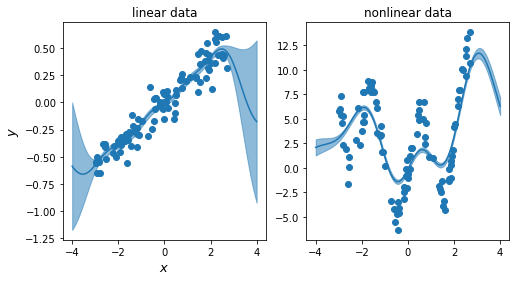

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

<a id='gp_hyp'></a>
### 4.2 Choosing hyperparameters

The added flexibility however does come with a cost. Unlike the above methods based on explicit fixed basis sets, we now have to specify the parameters of the kernel $\theta = (\sigma, l)$, which effectively shape the basis function set we use. The $\theta$ are called hyperparameters, as they are one level above the parameters $\mathbf{w}$ that are implicit in this formulation. Generally, this optimization 

$$ \min_{\theta} p(\mathbf{y}|\theta) $$

is not solvable in closed form, and one has to use iterative methods such as gradient descent. Luckily in JAX, this is easily done by computing gradients with ```grad```:

In [36]:
def log_marginal_likelihood(params, x_obs, y_obs, y_cov, kernel_func):
    d_x = y_obs.shape[0]
    
    Kxx = kernel_func(params, x_obs, x_obs)
    
    Le = jnp.linalg.cholesky(Kxx + y_cov)
    Ley = jsc.linalg.solve_triangular(Le, y_obs[:, None], lower=True)
    
    lml = -.5 * (Ley.T @ Ley).sum() - .5 * d_x * jnp.log(2 * jnp.pi) - jnp.log(jnp.diag(Le)).sum()
    return lml


In [37]:
# linear
loss_func = lambda p: -log_marginal_likelihood(p, x_data[:, None], y_linear, y_linear_cov, SE_kernel)
grad_lml = jax.jit(jax.value_and_grad(loss_func))  # JIT to make it fast

opt_init, opt_update, get_params = optimizers.adam(step_size=5e-3)
opt_state = opt_init(params_lin)

print('optimising the hyperparameters ...')

losses_lin = []
for i in range(1000):
    params_lin = get_params(opt_state)
    
    loss, gradients = grad_lml(params_lin)
    if (i % 100) == 0:
        print('iter %2d: nlml=%2.2f' % (i, loss))

    opt_state = opt_update(i, gradients, opt_state)
    losses_lin.append(loss)
    
    
# nonlinear
loss_func = lambda p: -log_marginal_likelihood(p, x_data[:, None], y_nonlinear, y_nonlinear_cov, SE_kernel)
grad_lml = jax.jit(jax.value_and_grad(loss_func))  # JIT to make it fast

opt_init, opt_update, get_params = optimizers.adam(step_size=5e-3)
opt_state = opt_init(params_non)

print('optimising the hyperparameters ...')

losses_non = []
for i in range(1000):
    params_non = get_params(opt_state)
    
    loss, gradients = grad_lml(params_non)
    if (i % 100) == 0:
        print('iter %2d: nlml=%2.2f' % (i, loss))

    opt_state = opt_update(i, gradients, opt_state)
    losses_non.append(loss)

optimising the hyperparameters ...
iter  0: nlml=-64.03
iter 100: nlml=-71.34
iter 200: nlml=-74.38
iter 300: nlml=-75.31
iter 400: nlml=-75.95
iter 500: nlml=-76.45
iter 600: nlml=-76.68
iter 700: nlml=-76.78
iter 800: nlml=-76.83
iter 900: nlml=-76.86
optimising the hyperparameters ...
iter  0: nlml=606.22
iter 100: nlml=269.98
iter 200: nlml=216.98
iter 300: nlml=200.07
iter 400: nlml=192.57
iter 500: nlml=188.69
iter 600: nlml=186.47
iter 700: nlml=185.11
iter 800: nlml=184.24
iter 900: nlml=183.66


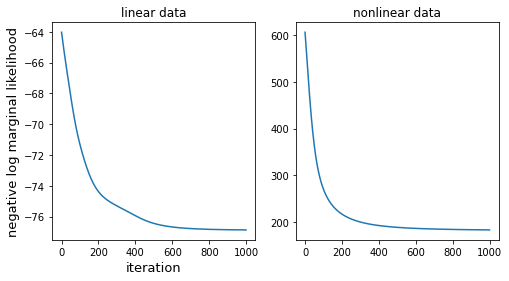

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(losses_lin)
axes[0].set_xlabel('iteration', fontsize=13)
axes[0].set_ylabel('negative log marginal likelihood', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(losses_non)

plt.show()

In [39]:
Kxx = SE_kernel(params_lin, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_lin, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])

post_mean_linear, post_cov_linear = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = jnp.sqrt(jnp.diag(post_cov_linear))


Kxx = SE_kernel(params_non, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_non, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_non, x_plot[:, None], x_plot[:, None])

post_mean_nonlinear, post_cov_nonlinear = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = jnp.sqrt(jnp.diag(post_cov_nonlinear))

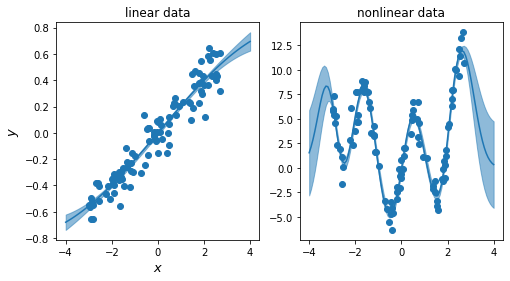

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

The marginal likelihood and test performance:

In [41]:
Kxx = SE_kernel(params_lin, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_lin, x_data[:, None], x_test[:, None])
Kss = SE_kernel(params_lin, x_test[:, None], x_test[:, None])
post_mean_linear, _ = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)

Kxx = SE_kernel(params_non, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_non, x_data[:, None], x_test[:, None])
Kss = SE_kernel(params_non, x_test[:, None], x_test[:, None])
post_mean_nonlinear, _ = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)

R2_linear = compute_R2(post_mean_linear, y_linear_test)
R2_nonlinear = compute_R2(post_mean_nonlinear, y_nonlinear_test)


LML_linear = log_marginal_likelihood(params_lin, x_data[:, None], y_linear, y_linear_cov, SE_kernel)
LML_nonlinear = log_marginal_likelihood(params_non, x_data[:, None], y_nonlinear, y_nonlinear_cov, SE_kernel)

gp_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
    "LML_linear": LML_linear, 
    "LML_nonlinear": LML_nonlinear, 
}

<a id='gp_note'></a>
### 4.3 A note on non-Gaussian observations

So far, we have ... GLMs, in the machine learning this is termed non-conjugate models as closed form solutions are generally not available. One needsd to rely on iterative algorithms to estimate model parameters.

<a id='notes'></a>
## 5. Comparing methods

So far, we have ... GLMs, in the machine learning this is termed non-conjugate models as closed form solutions are generally not available. One needsd to rely on iterative algorithms to estimate model parameters.

In [55]:
names = ['linear regression', 'Bayesian linear', 'cubic basis', 'Bayesian cubic', 'Gaussian process']

R2_linears = [
    linear_regression_dict["R2_linear"], 
    blinear_regression_dict["R2_linear"], 
    basis_regression_dict["R2_linear"], 
    bbasis_regression_dict["R2_linear"], 
    gp_regression_dict["R2_linear"], 
]

R2_nonlinears = [
    linear_regression_dict["R2_nonlinear"], 
    blinear_regression_dict["R2_nonlinear"], 
    basis_regression_dict["R2_nonlinear"], 
    bbasis_regression_dict["R2_nonlinear"], 
    gp_regression_dict["R2_nonlinear"], 
]

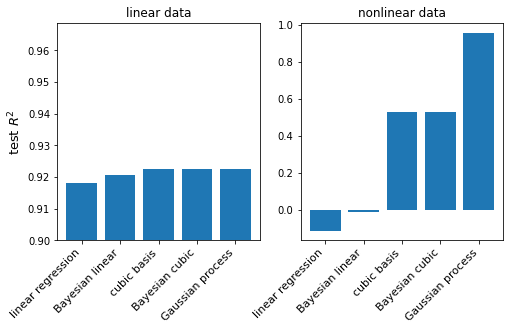

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].bar(np.arange(len(names)), R2_linears)
axes[0].set_xticks(np.arange(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right', fontsize=11)
axes[0].set_ylabel(r'test $R^2$', fontsize=13)
axes[0].set_ylim(0.9)

axes[1].set_title('nonlinear data')
axes[1].bar(np.arange(len(names)), R2_nonlinears)
axes[1].set_xticks(np.arange(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right', fontsize=11)


plt.show()